## Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from gan import preprocessing, tadgan, postprocessing, utils


In [2]:
# set constants and hyperparameters

DATASET = 'data/error_win_3.csv'
# Minimum value: 20.5
# Maximum value: 32.5
# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [3]:
# import time series

x = pd.read_csv(DATASET)

# x['time'] = pd.to_datetime(x['time'],format="%d-%m-%Y %H:%M:%S", dayfirst=True)
x.set_index('time', inplace=True)
x.index = pd.to_datetime(x.index)
x.sort_index(inplace=True)

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

x.describe()

temp = x['temperature']
# temp = temp[temp>=18]
# temp = temp.resample('H').mean()

train = temp[(temp.index.year>=2022)]
# test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

train.head()

Number of time stamps: 117
First 3 time stamps: 2023-02-11 05:52:35, 2023-02-11 06:12:38, 2023-02-11 06:13:10
Last 3 time stamps: 2023-02-12 02:55:52, 2023-02-12 03:01:26, 2023-02-12 03:20:12


time
2023-02-11 05:52:35    24.5
2023-02-11 06:12:38    24.4
2023-02-11 06:13:10    24.6
2023-02-11 06:32:45    24.4
2023-02-11 06:37:32    24.6
Name: temperature, dtype: float64

## Prepare Training Data


In [4]:
# apply preprocessing pipeline

train, t, x_win, t_win = preprocessing.new_apply_pipeline(train, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

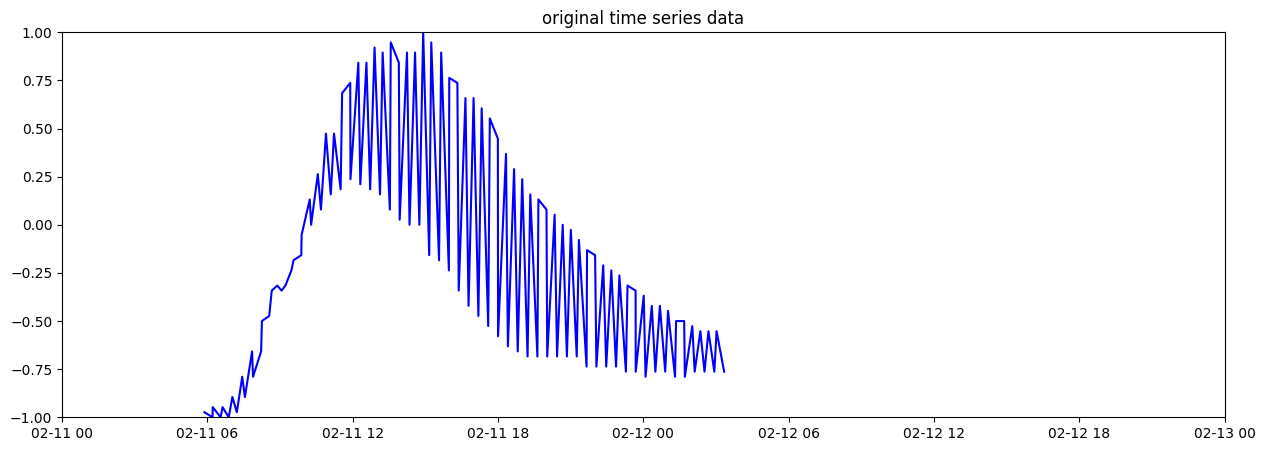

In [5]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=None, 
                       date_range=['2023-02-11', '2023-02-13'], value_range=[-1, 1],
                       title='original time series data')

In [11]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 2
Start times of the first 3 windows: ['2023-02-06T02:13:53.000000000' '2023-02-06T02:26:53.000000000']


## Train Reconstruction Model (TadGAN)

In [6]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [7]:
model.get_model("./model/model_tran_100_quy1_3m")

In [8]:
# generate reconstructed time series segments
x_win_recon, critic_scores = model.predict(x_win)
print(x_win_recon)
print(len(x_win_recon))
print(x_win_recon[0])
np.savetxt("redict_data_3.csv", x_win_recon, delimiter=",")

[[-0.84906894 -0.44999698 -0.8269228  -0.64828765 -0.70085704 -0.7706899
  -0.63744116 -0.80393314 -0.73201007 -0.73794514 -0.7658993  -0.77155167
  -0.79140455 -0.7356997  -0.7731378  -0.7562388  -0.74788165 -0.7456885
  -0.755607   -0.76715225 -0.698572   -0.7221345  -0.7002735  -0.697592
  -0.69814026 -0.67967963 -0.7214958  -0.69561285 -0.6596612  -0.5428144
  -0.41871384 -0.4041877  -0.38004744 -0.44950563 -0.45035735 -0.41269284
  -0.3648819  -0.3036622  -0.23698579 -0.26173952 -0.24456556 -0.19640177
  -0.15730652 -0.10422226 -0.09444677 -0.02006599  0.02099752  0.04405579
   0.10830258  0.06585964  0.13144554  0.13697119  0.20586261  0.21714139
   0.36389723  0.38692343  0.41795233  0.4545273   0.46621946  0.46955153
   0.40585628  0.6135264   0.43635917  0.4976032   0.39257598  0.6080363
   0.4877429   0.475561    0.68796515  0.34140798  0.5973756   0.4844727
   0.5633985   0.43469194  0.41740242  0.51810914  0.34130666  0.48939678
   0.23606704  0.51255536  0.17008933  0.4855

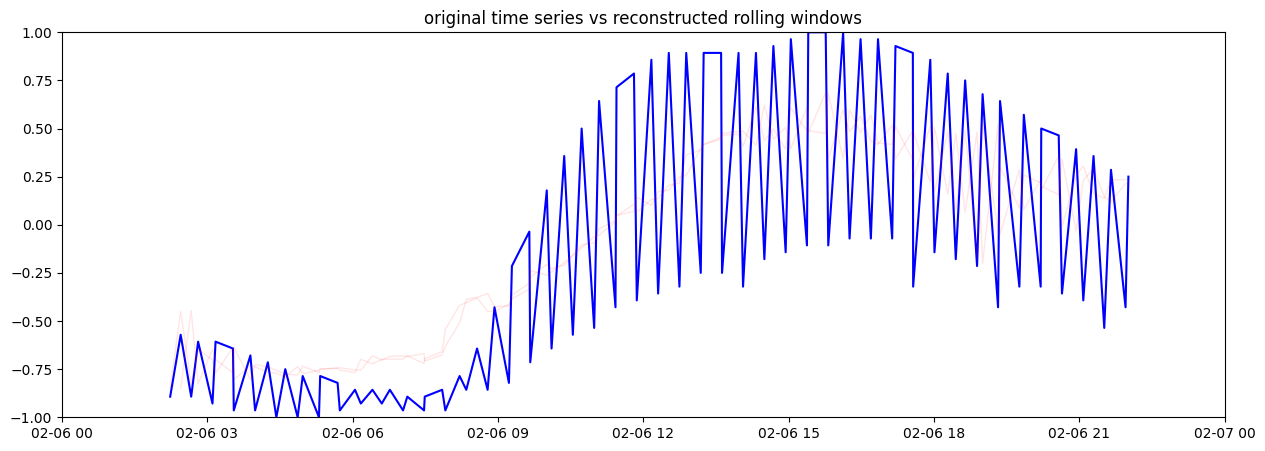

In [10]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=x_win_recon, 
                       date_range=['2023-02-11', '2023-02-13'], value_range=[-1, 1],
                       title='original time series vs reconstructed rolling windows')

In [11]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(train, t, x_win_recon, critic_scores, **params)
print(detected_intervals)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

[-0.71026534 -0.6102525  -0.7109772  ...  0.25785431  0.19687224
  0.22540925]
                start                 end      score
0 2023-01-06 17:20:39 2023-01-07 15:51:37  12.214416
1 2023-02-06 02:13:53 2023-02-06 22:00:51   4.006461
2 2023-02-11 05:52:35 2023-02-12 03:20:12   8.356626
3 2023-03-27 05:34:06 2023-03-27 21:25:27   4.171982


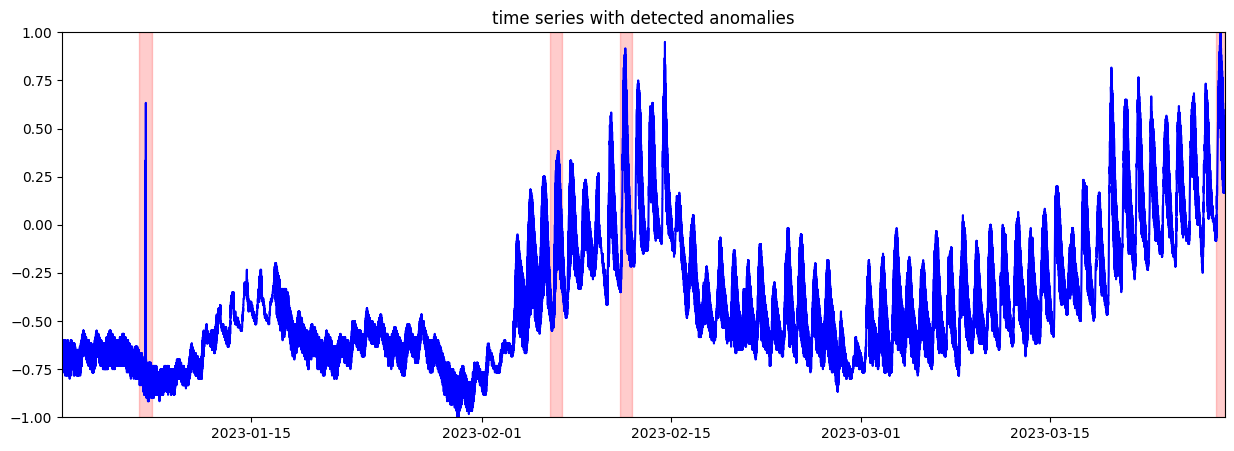

In [12]:
# plot time series with detected anomalies

utils.plot_time_series(t, train, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with detected anomalies')

In [17]:
x_reconstructed_scaled = preprocessing.inverse_rolling_windows(x_win_recon)
x_reconstructed = preprocessing.inverse_scale_data(x_reconstructed_scaled)

print('x_reconstructed',x_reconstructed)

x_reconstructed [-0.71026534 -0.6102525  -0.7109772  ...  0.25785431  0.19687224
  0.22540925]
